## 3DCORE for Faraday rotation

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import heliopy
import astropy
import datetime
from datetime import timedelta
import astropy.constants as const
from sunpy.time import parse_time
import heliopy.spice as spice
import heliopy.data.spice as spicedata
import seaborn as sns
import glob
from scipy.io import readsav
import os
import copy

#these are our own packages
import py3dcore
import heliosat



## 3DCORE functions

In [3]:
def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    ax.set_zlim([-view_radius, view_radius])
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)

    ax.scatter(0, 0, 0, color="y", s=500)

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs)

    
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = model_obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    
    
def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
def plot_circle(ax,dist,**kwargs):        

    thetac = np.linspace(0, 2 * np.pi, 100)
    xc=dist*np.sin(thetac)
    yc=dist*np.cos(thetac)
    zc=0
    ax.plot(xc,yc,zc,ls='--',color='black',lw=0.3,**kwargs)
      

def plot_satellite(ax,satpos1,**kwargs):

    xc=satpos1[0]*np.cos(np.radians(satpos1[1]))
    yc=satpos1[0]*np.sin(np.radians(satpos1[1]))
    zc=0
    #print(xc,yc,zc)
    ax.scatter3D(xc,yc,zc,**kwargs)


def measure(obj, satpos1, t0, t1, frame="HEEQ", bframe="HEE", satparams=None):
    
    #print(obj)
    print('input')
    print(t0,' / ', t1, frame, bframe)
    
    #if satparams:
    #    inst = getattr(heliosat, sat)(satparams)
    #else:
    #    inst = getattr(heliosat, sat)()        
    #print(inst)    
    #time resolution in seconds
    #t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]    
    #position of spacecraft
    #o_s = inst.trajectory(t_s, frame=frame)
    
    #time resolution in hours
    res_in_days=1/24.    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    print('data points',len(t_s))
    
    #generate position from satpos - always constant
    o_s=np.zeros([len(t_s),3])
    o_s[:,0]=satpos1[0]   #R in AU 
    o_s[:,1]=np.radians(satpos1[1]) #longitude
    o_s[:,2]=np.radians(satpos1[2]) #latitude

    #print(t_s)
    #print(o_s)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b, o_s    

In [4]:
t_launch = datetime.datetime(2020, 12, 7, 18,0,0)



#2020 Dec 7: COR2 15 solar radii 18 UT


iparams_arr = np.array([[
    0,      # time offset
    0,    # l_1 (logitude) HEEQ
    0,#-20,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.2,   # d_1au (frontal width at 1AU)
    3,   # delta (cross-section aspect ratio)
    15,      # r_0 (initialization distance in solar radii)
    1670,    # v_0 (initial velocty in)
    4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    25,     # b_1au (magnetic field strength at 1au)
    0.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=1)
tm1 =  t_launch + datetime.timedelta(days=3.5)
tm2 =  t_launch + datetime.timedelta(days=5.0)


#colors for 3dplots

c0 = 'mediumseagreen'
c1 = "xkcd:red"
c2 = "xkcd:blue"


#colors for components in plots
cbt = "xkcd:black"
cbx = "xkcd:magenta"
cby = "xkcd:orange"
cbz = "xkcd:azure"

############# define synthetic satellite positions - semi-circle at 1 AU, from -90 to +90 longitude

lonstart=-90
lonstep=5
lonend=90

lonend=lonend+lonstep
satpos=np.zeros(len(np.arange(lonstart,lonend,lonstep)),dtype=[('r',float),('lon', float),('lat', float)])
#convert to recarray
satpos = satpos.view(np.recarray)  

##### set position
satpos.r=1.0
satpos.lon=np.arange(lonstart,lonend,lonstep)
satpos.lat=0.0

print(satpos.r, satpos.lon)    

#another satpos definition for a semi circle at 0.5 AU
satpos2=copy.deepcopy(satpos)
satpos2.r=0.5

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [-90. -85. -80. -75. -70. -65. -60. -55. -50. -45. -40. -35. -30. -25.
 -20. -15. -10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.
  50.  55.  60.  65.  70.  75.  80.  85.  90.]


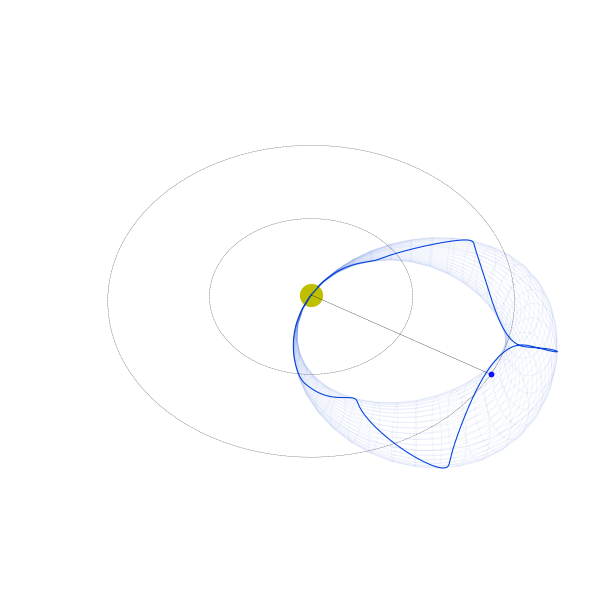

In [9]:
#use either 
#%matplotlib 
#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#%matplotlib inline


sns.set_context("talk")     
#sns.set_style('whitegrid',{'grid.linestyle': '--'})

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(15,9),dpi=70)
ax = fig.add_subplot(111, projection='3d')

#plot_configure(ax, view_azim=0, view_elev=0, view_radius=0.8)
#in other planes
plot_configure(ax, view_azim=-60, view_elev=50, view_radius=0.9)
#plot_configure(ax, view_azim=0, view_elev=0, view_radius=0.6)


########## 3dcore plots
#plot_3dcore(ax, model_obj, tm0, color=c1)
#plot_3dcore_field(ax, model_obj, color=c1, step_size=0.005, lw=1.1, ls="-",q0=np.array([1, .1, np.pi/2]))

plot_3dcore(ax, model_obj, tm1, color=c2)
plot_3dcore_field(ax, model_obj, color=c2, step_size=0.005, lw=1.1, ls="-")

############# satellite plots
#plot_traj(ax, "Earth", tm1, frame="HEEQ", color=c1)
  
    
#for i in np.arange(0,len(satpos)):
#    plot_satellite(ax,satpos[i],color='black',alpha=0.9)    
#    plot_satellite(ax,satpos2[i],color='red',alpha=0.9)

plot_satellite(ax,satpos[18],color='blue',alpha=0.9)



##########cosmetics
#approximate Sun Earth line
ax.plot([0,1],[0,0],[0,0],ls='-',color='black',lw=0.3)

plot_circle(ax,0.5)
plot_circle(ax,1.0)

#plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
#plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
#


#plot thux





plt.tight_layout()

#see folder content in the colab
plt.savefig('results/test_thux_3dcore/test.pdf')
#plt.savefig('test.png', dpi=100)


current satpos measured is  18
(1., 0., 0.)
input
2020-12-08 06:00:00  /  2020-12-26 06:00:00 HEEQ HEE
data points 432


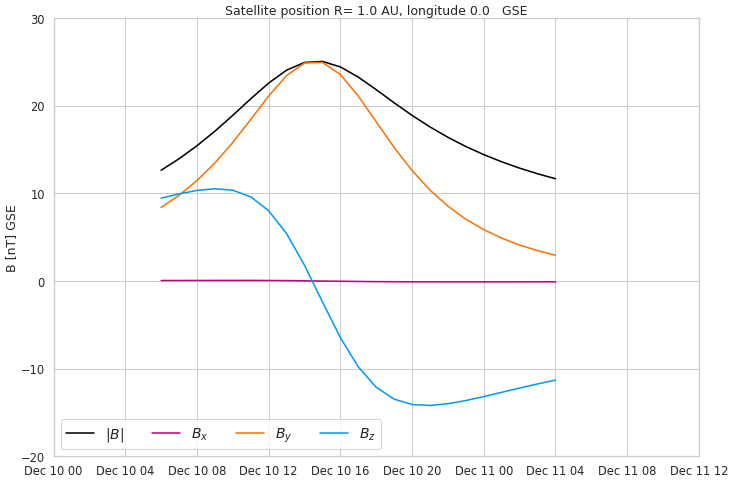

In [6]:
############################### measure magnetic field
print()


#18 is middle
satposindex=18
print('current satpos measured is ', satposindex)
print(satpos[satposindex])


t1, btot1, bxyz1, os1 = measure(model_obj, satpos[satposindex], tm1 - datetime.timedelta(days=3), tm1  + datetime.timedelta(days=15))


################################################
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(15, 10),dpi=50)

ax1 = fig.add_subplot(111)
ax1.set_title('Satellite position R= 1.0 AU, longitude '+str(satpos.lon[satposindex])+'   GSE')

ax1.plot(t1, btot1, color=cbt, label="$|B|$")
ax1.plot(t1, -bxyz1[:, 0], color=cbx, label="$B_x$")
ax1.plot(t1, -bxyz1[:, 1], color=cby, label="$B_y$")
ax1.plot(t1, bxyz1[:, 2], color=cbz, label="$B_z$")

ax1.legend(loc="lower left", fontsize=20,ncol=4)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H'))
ax1.set_ylabel('B [nT] GSE')
plt.ylim(-20,30)
plt.xlim(datetime.datetime(2020,12,10,0,0,0),datetime.datetime(2020,12,11,12,0,0))


#ax1.plot(noaa.time,noaa.bt,color=cbt)
#ax1.plot(noaa.time,noaa.bx,color=cbx)
#ax1.plot(noaa.time,noaa.by,color=cby)
#ax1.plot(noaa.time,noaa.bz,color=cbz)
plt.tight_layout()

plt.savefig('test_measure_1.png', dpi=50)
plt.savefig('test_measure_1.pdf', dpi=50)